# Data 144 Final Project: UK Car Accident Classifier

Authors: Jason Dai, Dana You, Jason Han, Abdumijit Dolkun

Importing necessary packages

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.pipeline import Pipeline
from sklearn.svm import SVC, LinearSVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.model_selection import train_test_split, KFold, cross_val_score, GridSearchCV, ParameterGrid

Reading in CSVs and generating dataframes

In [ ]:
df_accident = pd.read_csv('Accidents0514.csv')
df_casualty = pd.read_csv('Casualties0514.csv')
df_vehicle = pd.read_csv('Vehicles0514.csv')

/shared-libs/python3.9/py-core/lib/python3.9/site-packages/IPython/core/interactiveshell.py:3139: DtypeWarning: Columns (31) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


Dataframe information

In [ ]:
df_accident.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1640597 entries, 0 to 1640596
Data columns (total 32 columns):
 #   Column                                       Non-Null Count    Dtype  
---  ------                                       --------------    -----  
 0   Accident_Index                               1640597 non-null  object 
 1   Location_Easting_OSGR                        1640486 non-null  float64
 2   Location_Northing_OSGR                       1640486 non-null  float64
 3   Longitude                                    1640486 non-null  float64
 4   Latitude                                     1640486 non-null  float64
 5   Police_Force                                 1640597 non-null  int64  
 6   Accident_Severity                            1640597 non-null  int64  
 7   Number_of_Vehicles                           1640597 non-null  int64  
 8   Number_of_Casualties                         1640597 non-null  int64  
 9   Date                                         1

In [ ]:
df_casualty.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2216720 entries, 0 to 2216719
Data columns (total 15 columns):
 #   Column                              Dtype 
---  ------                              ----- 
 0   Accident_Index                      object
 1   Vehicle_Reference                   int64 
 2   Casualty_Reference                  int64 
 3   Casualty_Class                      int64 
 4   Sex_of_Casualty                     int64 
 5   Age_of_Casualty                     int64 
 6   Age_Band_of_Casualty                int64 
 7   Casualty_Severity                   int64 
 8   Pedestrian_Location                 int64 
 9   Pedestrian_Movement                 int64 
 10  Car_Passenger                       int64 
 11  Bus_or_Coach_Passenger              int64 
 12  Pedestrian_Road_Maintenance_Worker  int64 
 13  Casualty_Type                       int64 
 14  Casualty_Home_Area_Type             int64 
dtypes: int64(14), object(1)
memory usage: 253.7+ MB


In [ ]:
df_vehicle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3004425 entries, 0 to 3004424
Data columns (total 22 columns):
 #   Column                            Dtype 
---  ------                            ----- 
 0   Accident_Index                    object
 1   Vehicle_Reference                 int64 
 2   Vehicle_Type                      int64 
 3   Towing_and_Articulation           int64 
 4   Vehicle_Manoeuvre                 int64 
 5   Vehicle_Location-Restricted_Lane  int64 
 6   Junction_Location                 int64 
 7   Skidding_and_Overturning          int64 
 8   Hit_Object_in_Carriageway         int64 
 9   Vehicle_Leaving_Carriageway       int64 
 10  Hit_Object_off_Carriageway        int64 
 11  1st_Point_of_Impact               int64 
 12  Was_Vehicle_Left_Hand_Drive?      int64 
 13  Journey_Purpose_of_Driver         int64 
 14  Sex_of_Driver                     int64 
 15  Age_of_Driver                     int64 
 16  Age_Band_of_Driver                int64 
 17  Engine_C

EDA & data cleaning plan:

Category 1: Weather Conditions: Columns: ['Road_Surface_Conditions', 'Weather_Conditions', 'Light_Conditions'] 

Category 2: Driver Demographics: Columns: ['Age_of_Driver', 'Sex_of_Driver'] 

Category 3: Vehicle Data: Columns: ['Engine_Capacity_(CC)', 'Age_of_Vehicle'] 

Dependent Variables and ID: Columns: ['Accident_Index', 'Accident_Severity', 'Casualty_Severity', 'Age_of_Casualty', 'Sex of Casualty'] 

Generating a single dataframe with selected features

In [ ]:
accident_columns = ['Accident_Index', 'Accident_Severity', 'Road_Surface_Conditions', 'Weather_Conditions', 'Light_Conditions']
casualty_columns = ['Accident_Index', 'Casualty_Severity', 'Age_of_Casualty', 'Sex_of_Casualty']
vehicle_columns = ['Accident_Index', 'Engine_Capacity_(CC)', 'Age_of_Vehicle', 'Age_of_Driver', 'Sex_of_Driver']

# New dataframe with reduced columns
df_accident_reduced = df_accident[accident_columns]
df_casualty_reduced = df_casualty[casualty_columns]
df_vehicle_reduced = df_vehicle[vehicle_columns]

In [ ]:
# Merging datasets into singular dataset
merged_df = pd.merge(df_accident_reduced, df_casualty_reduced, on='Accident_Index', how='inner')
merged_df = pd.merge(merged_df, df_vehicle_reduced, on='Accident_Index', how='inner')

In [ ]:
# Removing duplicates in the Accident_Index column
merged_df = merged_df.drop_duplicates(subset='Accident_Index',keep='first')

In [ ]:
# Display of first 20 rows of dataframe
merged_df.head(20)

,Accident_Index,Accident_Severity,Road_Surface_Conditions,Weather_Conditions,Light_Conditions,Casualty_Severity,Age_of_Casualty,Sex_of_Casualty,Engine_Capacity_(CC),Age_of_Vehicle,Age_of_Driver,Sex_of_Driver
0,200501BS00001,2,2,2,1,2,37,1,-1,-1,74,2
1,200501BS00002,3,1,1,4,3,37,1,8268,3,42,1
2,200501BS00003,3,1,1,4,3,62,1,8300,5,35,1
4,200501BS00004,3,1,1,1,3,30,1,1769,4,49,2
5,200501BS00005,3,2,1,7,3,49,1,85,10,49,1
6,200501BS00006,3,2,2,1,3,30,2,2976,1,51,1
8,200501BS00007,3,1,1,4,3,31,1,-1,-1,31,1
10,200501BS00009,3,1,1,1,3,13,2,5343,16,68,1
12,200501BS00010,3,1,1,4,3,35,1,1998,13,35,1
16,200501BS00011,3,1,1,1,3,26,2,8268,2,42,1


Feature engineering

Cleaning ['Road_Surface_Conditions', 'Weather_Conditions', 'Light_Conditions'] 

In [ ]:
# Road surface conditions cleaning
rd_null = merged_df['Road_Surface_Conditions'].isnull().sum()
print(rd_null)

cleaned_df = merged_df.copy()
n = -1
cleaned_df = cleaned_df[cleaned_df['Road_Surface_Conditions'] != n]

# Weather conditions cleaning (removing -1 and 9)
w_null = merged_df['Weather_Conditions'].isnull().sum()
print(w_null)
m = 9
cleaned_df = cleaned_df[cleaned_df['Weather_Conditions'] != m]
cleaned_df = cleaned_df[cleaned_df['Weather_Conditions'] != n]

# Light conditions cleaning
l_null = merged_df['Light_Conditions'].isnull().sum()
print(l_null)
cleaned_df = cleaned_df[cleaned_df['Light_Conditions'] != n]

# All 3 are categorical and they have no nulls or -1
# One hot encoding for all
cleaned_df = pd.get_dummies(cleaned_df, columns=['Road_Surface_Conditions','Weather_Conditions','Light_Conditions'])
cleaned_df

0
0
0


,Accident_Index,Accident_Severity,Casualty_Severity,Age_of_Casualty,Sex_of_Casualty,Engine_Capacity_(CC),Age_of_Vehicle,Age_of_Driver,Sex_of_Driver,Road_Surface_Conditions_1,...,Weather_Conditions_4,Weather_Conditions_5,Weather_Conditions_6,Weather_Conditions_7,Weather_Conditions_8,Light_Conditions_1,Light_Conditions_4,Light_Conditions_5,Light_Conditions_6,Light_Conditions_7
0,200501BS00001,2,2,37,1,-1,-1,74,2,0,...,0,0,0,0,0,1,0,0,0,0
1,200501BS00002,3,3,37,1,8268,3,42,1,1,...,0,0,0,0,0,0,1,0,0,0
2,200501BS00003,3,3,62,1,8300,5,35,1,1,...,0,0,0,0,0,0,1,0,0,0
4,200501BS00004,3,3,30,1,1769,4,49,2,1,...,0,0,0,0,0,1,0,0,0,0
5,200501BS00005,3,3,49,1,85,10,49,1,0,...,0,0,0,0,0,0,0,0,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4287576,2014984136414,2,2,24,1,2148,5,24,1,0,...,0,0,0,0,0,0,0,0,1,0
4287578,2014984137514,3,3,30,1,12900,3,30,1,0,...,0,0,0,0,0,0,0,0,1,0
4287582,2014984137714,3,3,16,2,1391,15,21,1,0,...,0,0,0,0,0,0,1,0,0,0
4287583,2014984138414,2,3,27,1,1781,12,27,1,0,...,0,0,0,0,0,0,0,0,1,0


Cleaning ['Age_of_Driver', 'Sex_of_Driver']

In [ ]:
# Age_of_Driver Cleaning
# Check for -1 values and then remove them
age_drv_null = cleaned_df['Age_of_Driver'].isnull().sum()
age_drv_minus_one = (cleaned_df['Age_of_Driver'] == -1).sum()
print('Age_of_Driver - Null:', age_drv_null)
print('Age_of_Driver - -1:', age_drv_minus_one)

cleaned_df = cleaned_df[cleaned_df['Age_of_Driver'] != -1]

#one-hot encoding age_of_driver
bins=[0, 12, 18, 35, 50, float('inf')]
labels = ['1', '2', '3', '4', '5']
cleaned_df['Driver_Age_Group'] = pd.cut(cleaned_df['Age_of_Driver'],  bins=bins, labels=labels, include_lowest=True, right=True)

# Sex_of_Driver Cleaning
# Check for -1 values and then remove them
sex_drv_null = cleaned_df['Sex_of_Driver'].isnull().sum()
sex_drv_minus_one = (cleaned_df['Sex_of_Driver'] == -1).sum()
cleaned_df = cleaned_df[cleaned_df['Sex_of_Driver'] != 3]
print('Sex_of_Driver - Null:', sex_drv_null)
print('Sex_of_Driver - -1:', sex_drv_minus_one)

cleaned_df = cleaned_df[cleaned_df['Sex_of_Driver'] != -1]

# Assuming 'Sex_of_Driver' is a categorical variable that should be one-hot encoded
cleaned_df = pd.get_dummies(cleaned_df, columns=['Sex_of_Driver'])
cleaned_df = cleaned_df.drop(columns=['Age_of_Driver'])
cleaned_df

Age_of_Driver - Null: 0
Age_of_Driver - -1: 157171
/tmp/ipykernel_481/1016454962.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  cleaned_df['Driver_Age_Group'] = pd.cut(cleaned_df['Age_of_Driver'],  bins=bins, labels=labels, include_lowest=True, right=True)
Sex_of_Driver - Null: 0
Sex_of_Driver - -1: 1


,Accident_Index,Accident_Severity,Casualty_Severity,Age_of_Casualty,Sex_of_Casualty,Engine_Capacity_(CC),Age_of_Vehicle,Road_Surface_Conditions_1,Road_Surface_Conditions_2,Road_Surface_Conditions_3,...,Weather_Conditions_7,Weather_Conditions_8,Light_Conditions_1,Light_Conditions_4,Light_Conditions_5,Light_Conditions_6,Light_Conditions_7,Driver_Age_Group,Sex_of_Driver_1,Sex_of_Driver_2
0,200501BS00001,2,2,37,1,-1,-1,0,1,0,...,0,0,1,0,0,0,0,5,0,1
1,200501BS00002,3,3,37,1,8268,3,1,0,0,...,0,0,0,1,0,0,0,4,1,0
2,200501BS00003,3,3,62,1,8300,5,1,0,0,...,0,0,0,1,0,0,0,3,1,0
4,200501BS00004,3,3,30,1,1769,4,1,0,0,...,0,0,1,0,0,0,0,4,0,1
5,200501BS00005,3,3,49,1,85,10,0,1,0,...,0,0,0,0,0,0,1,4,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4287576,2014984136414,2,2,24,1,2148,5,0,0,1,...,0,0,0,0,0,1,0,3,1,0
4287578,2014984137514,3,3,30,1,12900,3,0,0,1,...,0,0,0,0,0,1,0,3,1,0
4287582,2014984137714,3,3,16,2,1391,15,0,0,0,...,0,0,0,1,0,0,0,3,1,0
4287583,2014984138414,2,3,27,1,1781,12,0,1,0,...,0,0,0,0,0,1,0,3,1,0


Cleaning ['Engine_Capacity_(CC)', 'Age_of_Vehicle'] 

Engine_Capacity Null Count: 0
Age_of_vehicle Null Count: 0


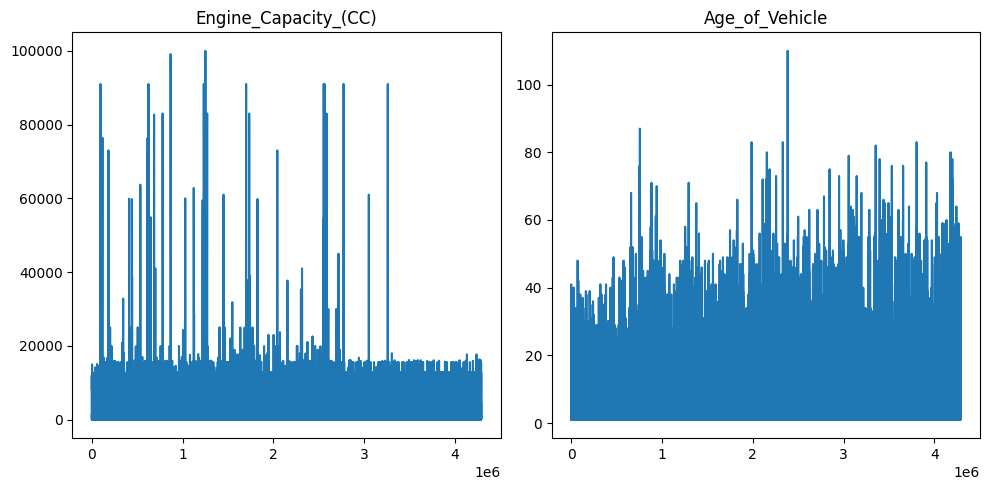

In [ ]:
# Engine_Capacity cleaning
cc_null = cleaned_df['Engine_Capacity_(CC)'].isnull().sum()
print("Engine_Capacity Null Count:", cc_null)
cleaned_df = cleaned_df[cleaned_df['Engine_Capacity_(CC)'] != -1]

# Age_of_Vehicle cleaning
vAge_null = cleaned_df['Age_of_Vehicle'].isnull().sum()
print("Age_of_vehicle Null Count:",vAge_null)
cleaned_df = cleaned_df[cleaned_df['Age_of_Vehicle'] != -1]

# Create a figure with two subplots
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot for 'Engine_Capacity_(CC)'
axs[0].plot(cleaned_df['Engine_Capacity_(CC)'].dropna())
axs[0].set_title('Engine_Capacity_(CC)')

# Plot for 'Age_of_Vehicle'
axs[1].plot(cleaned_df['Age_of_Vehicle'].dropna())
axs[1].set_title('Age_of_Vehicle')

# Show the figure
plt.tight_layout()
plt.show()

# Binning 'Engine_Capacity_(CC)'
bins = [0, 200, 1000, 2500, float('inf')]
labels = ['<200','200-1000', '1000-2500', '>2500']
cleaned_df['Engine_Capacity_Bin'] = pd.cut(cleaned_df['Engine_Capacity_(CC)'], bins=bins, labels=labels)

# Binning 'Age_of_Vehicle'
bins = [0, 3, 7, 10, 20, float('inf')]
labels = ['<3', '3-7', '7-10', '10-20', '>20']
cleaned_df['Age_of_Vehicle_Bin'] = pd.cut(cleaned_df['Age_of_Vehicle'], bins=bins, labels=labels)

# One-hot encoding for 'Engine_Capacity_(CC)' and 'Age_of_Vehicle'
cleaned_df = pd.get_dummies(cleaned_df, columns=['Engine_Capacity_Bin', 'Age_of_Vehicle_Bin'])

cleaned_df = cleaned_df.drop(columns=['Engine_Capacity_(CC)', 'Age_of_Vehicle', 'Accident_Index'])

Cleaning ['Accident_Index', 'Accident_Severity', 'Casualty_Severity', 'Age_of_Casualty', 'Sex of Casualty'] 

In [ ]:
# Cleaning Dependent Vars + ID
# Columns: ['Accident_Index', 'Accident_Severity', 'Casualty_Severity', 'Age_of_Casualty', 'Sex of Casualty']
from sklearn.preprocessing import StandardScaler

# 1. accident index are not unique rn –> what to do?
print(len(merged_df), merged_df['Accident_Index'].nunique())

# 2. accident severity range: 1-3 ; no null
acc_null = merged_df['Accident_Severity'].isnull().sum()
print(acc_null)

# 3. casualty severity range: 1-3 ; no null
cas_null = merged_df['Casualty_Severity'].isnull().sum()
print(cas_null)

# 4a. age of casualty range 9-62 ; no null
age_null = merged_df['Age_of_Casualty'].isnull().sum()
print(age_null)

# 4b. drop -1 null values in age of casualty
value_to_drop = -1
cleaned_df = cleaned_df[cleaned_df['Age_of_Casualty'] != value_to_drop]

# 4c. creating bins for casualty age (should i also one-hot encode these categories?)
bins=[0, 12, 18, 35, 50, float('inf')]
labels = ['1', '2', '3', '4', '5']
cleaned_df['Casualty_Age_Group'] = pd.cut(cleaned_df['Age_of_Casualty'],  bins=bins, labels=labels, include_lowest=True, right=True)

# age_group_null = cleaned_df['Casualty_Age_Group'].isnull().sum()
# print(age_group_null)
print(cleaned_df['Casualty_Age_Group'])
cleaned_df = cleaned_df.drop(columns=['Age_of_Casualty'])

# 5a. drop -1 null values in sex of casualty 
value_to_drop = -1
cleaned_df = cleaned_df[cleaned_df['Sex_of_Casualty'] != value_to_drop]

# 5b. one-hot encode sex of casualty + rename columns
cleaned_df = pd.get_dummies(cleaned_df, columns=['Sex_of_Casualty'], prefix='Sex_of_Casualty')
cleaned_df.rename(columns={'Sex_of_Casualty_1': 'Casualty_M'}, inplace=True)
cleaned_df.rename(columns={'Sex_of_Casualty_2': 'Casualty_F'}, inplace=True)
print(cleaned_df.head())

1640597 1640597
0
0
0
1          4
2          5
4          3
5          4
6          3
          ..
4287576    3
4287578    3
4287582    2
4287583    3
4287589    5
Name: Casualty_Age_Group, Length: 1087904, dtype: category
Categories (5, object): ['1' < '2' < '3' < '4' < '5']
   Accident_Severity  Casualty_Severity  Road_Surface_Conditions_1  \
1                  3                  3                          1   
2                  3                  3                          1   
4                  3                  3                          1   
5                  3                  3                          0   
6                  3                  3                          0   

   Road_Surface_Conditions_2  Road_Surface_Conditions_3  \
1                          0                          0   
2                          0                          0   
4                          0                          0   
5                          1                          0   
6     

Correlation Graph:

<AxesSubplot: >

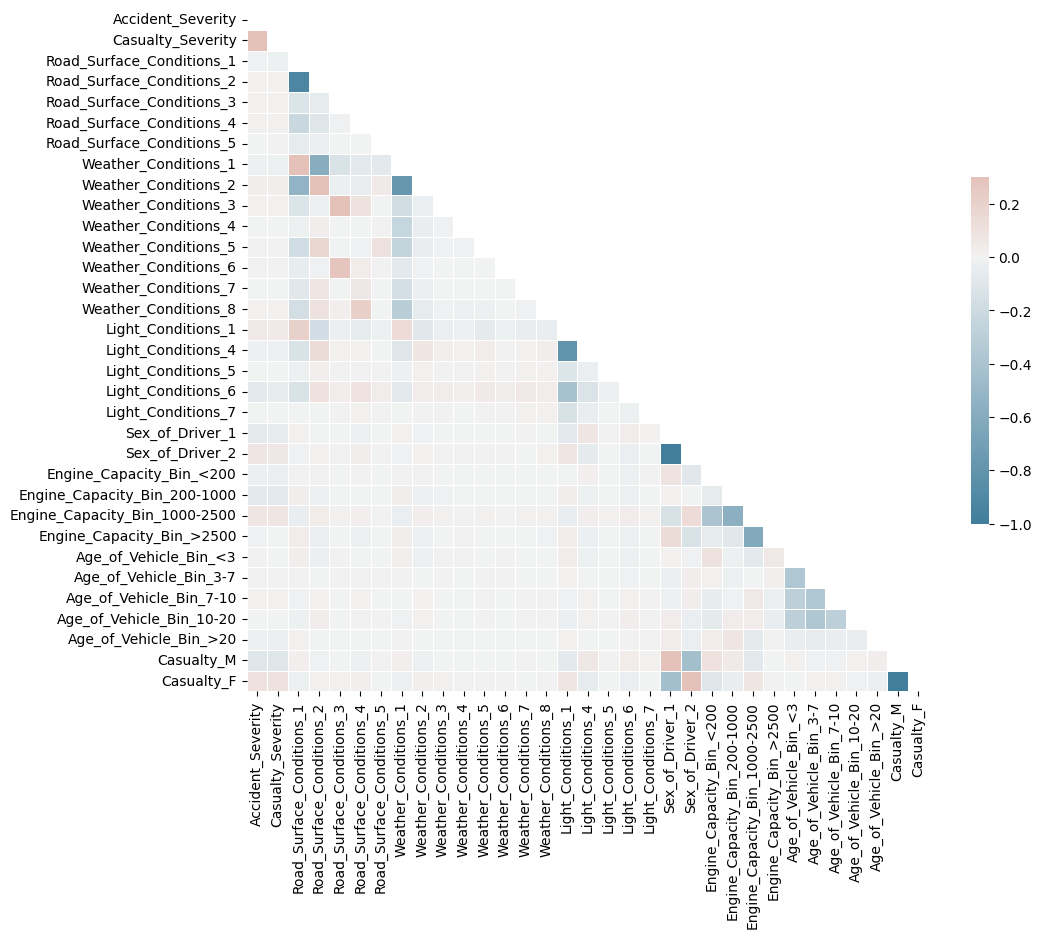

In [ ]:
# Compute the correlation matrix
corr = cleaned_df.corr()

# Generate a mask for the upper triangle
mask = np.triu(np.ones_like(corr, dtype=bool))

# Set up the matplotlib figure
f, ax = plt.subplots(figsize=(11, 9))

# Generate a custom diverging colormap
cmap = sns.diverging_palette(230, 20, as_cmap=True)

# Draw the heatmap with the mask and correct aspect ratio
sns.heatmap(corr, mask=mask, cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .5})


In [ ]:
cleaned_df = cleaned_df.drop(columns=['Casualty_Age_Group', 'Driver_Age_Group'])

In [ ]:
cleaned_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1087860 entries, 1 to 4287589
Data columns (total 33 columns):
 #   Column                         Non-Null Count    Dtype
---  ------                         --------------    -----
 0   Accident_Severity              1087860 non-null  int64
 1   Casualty_Severity              1087860 non-null  int64
 2   Road_Surface_Conditions_1      1087860 non-null  uint8
 3   Road_Surface_Conditions_2      1087860 non-null  uint8
 4   Road_Surface_Conditions_3      1087860 non-null  uint8
 5   Road_Surface_Conditions_4      1087860 non-null  uint8
 6   Road_Surface_Conditions_5      1087860 non-null  uint8
 7   Weather_Conditions_1           1087860 non-null  uint8
 8   Weather_Conditions_2           1087860 non-null  uint8
 9   Weather_Conditions_3           1087860 non-null  uint8
 10  Weather_Conditions_4           1087860 non-null  uint8
 11  Weather_Conditions_5           1087860 non-null  uint8
 12  Weather_Conditions_6           1087860 non

Splitting dataframe into train and test sets

In [ ]:
# Splitting dataset into train and test split
X = cleaned_df.drop(['Accident_Severity', 'Casualty_Severity'], axis=1)
y = cleaned_df['Accident_Severity']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state=42 )

Modeling and Classification:

K-Nearest Neighbors (KNN)

In [ ]:
k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

knn_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('knn', KNeighborsClassifier(n_neighbors=5)) 
])
knn_pipeline.fit(X_train, y_train)

knn_cv_scores = cross_val_score(knn_pipeline, X_train, y_train, cv=k_fold, scoring='accuracy')
avg_cv_accuracy = np.mean(knn_cv_scores)

y_pred = knn_pipeline.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred) 

print(f"Average KNN Cross-Validation Accuracy: {avg_cv_accuracy * 100:.2f}%")
print(f"KNN Test Accuracy: {test_accuracy * 100:.2f}%")

Average KNN Cross-Validation Accuracy: 81.11%
KNN Test Accuracy: 80.76%


Decision Tree

In [ ]:
decision_tree = DecisionTreeClassifier(random_state=42)
decision_tree.fit(X_train, y_train)

dt_cv_scores = cross_val_score(decision_tree, X_train, y_train, cv=k_fold, scoring='accuracy')
avg_cv_accuracy = np.mean(dt_cv_scores)

y_pred = decision_tree.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred) 

print(f"Average Decisoin Tree Cross-Validation Accuracy: {avg_cv_accuracy * 100:.2f}%")
print(f"Decisoin Tree Test Accuracy: {test_accuracy * 100:.2f}%")

Average Decisoin Tree Cross-Validation Accuracy: 84.46%
Decisoin Tree Test Accuracy: 84.49%


Random Forest

In [ ]:
rforest = RandomForestClassifier(n_estimators=100, random_state=42)
rforest.fit(X_train, y_train)

rf_cv_scores = cross_val_score(rforest, X_train, y_train, cv=k_fold, scoring='accuracy')
avg_cv_accuracy = np.mean(rf_cv_scores)

y_pred = rforest.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred) 

print(f"Average Random Forest Cross-Validation Accuracy: {avg_cv_accuracy * 100:.2f}%")
print(f"Random Forest Test Accuracy: {test_accuracy * 100:.2f}%")

Average Random Forest Cross-Validation Accuracy: 84.50%
Random Forest Test Accuracy: 84.53%


Logistic Regression

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

lreg = LogisticRegression(max_iter=1000)
lreg.fit(X_train_scaled, y_train)

lreg_cv_scores = cross_val_score(lreg, X_train_scaled, y_train, cv=k_fold, scoring='accuracy')
avg_cv_accuracy = np.mean(lreg_cv_scores)

y_pred = lreg.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred)

print(f"Average Logistic Regression Cross-Validation Accuracy: {avg_cv_accuracy * 100:.2f}%")
print(f"Logistic Regression Test Accuracy: {test_accuracy * 100:.2f}%")

Average Logistic Regression Cross-Validation Accuracy: 84.54%
Logistic Regression Test Accuracy: 84.56%


Neural Networks

In [ ]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.fit_transform(X_test)

nn = MLPClassifier(
    hidden_layer_sizes=(30),
    activation='logistic',
    solver='lbfgs',
    random_state=42
)
nn.fit(X_train_scaled, y_train)

nn_cv_scores = cross_val_score(nn, X_train_scaled, y_train, cv=k_fold, scoring='accuracy', error_score='raise')
avg_cv_accuracy = np.mean(nn_cv_scores)

y_pred = nn.predict(X_test_scaled)
test_accuracy = accuracy_score(y_test, y_pred) 

print(f"Average Neural Networks Cross-Validation Accuracy: {avg_cv_accuracy * 100:.2f}%")
print(f"Neural Networks Test Accuracy: {test_accuracy * 100:.2f}%")

Average Neural Networks Cross-Validation Accuracy: 84.54%
Neural Networks Test Accuracy: 84.56%


Ensemble Methods (Logistic Regression and Random Forest)

In [ ]:
ensemble = VotingClassifier(
    estimators=[
        ('lreg', lreg),
        ('rf', rforest)
        ],
    voting='hard')
ensemble.fit(X_train, y_train)
    
ensemble_cv_scores = cross_val_score(ensemble, X_train, y_train, cv=k_fold, scoring='accuracy')
avg_cv_accuracy = np.mean(ensemble_cv_scores)

y_pred = nn.predict(X_test)
test_accuracy = accuracy_score(y_test, y_pred) 

print(f"Average Ensemble Cross-Validation Accuracy: {avg_cv_accuracy * 100:.2f}%")
print(f"Ensemble Test Accuracy: {test_accuracy * 100:.2f}%")

Average Ensemble Cross-Validation Accuracy: 84.50%
Ensemble Test Accuracy: 84.56%
/shared-libs/python3.9/py/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but MLPClassifier was fitted without feature names
  warnings.warn(


Feature Importance

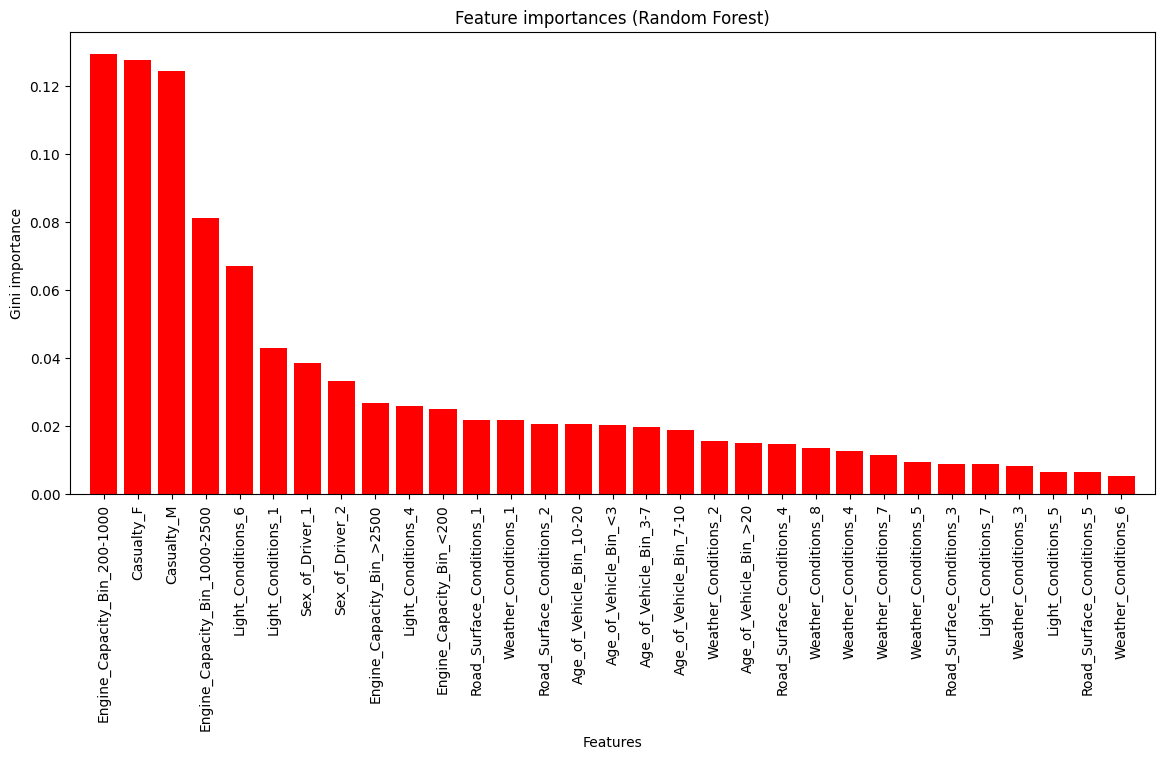

In [ ]:
importances = rforest.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X.columns

plt.figure(figsize=(14,6))
plt.bar(range(X.shape[1]), importances[indices], color="r")
plt.xticks(range(X.shape[1]), [feature_names[i] for i in indices], rotation='vertical')
plt.xlim([-1, X.shape[1]])

plt.title("Feature importances (Random Forest)")
plt.xlabel("Features")
plt.ylabel("Gini importance")
plt.show()

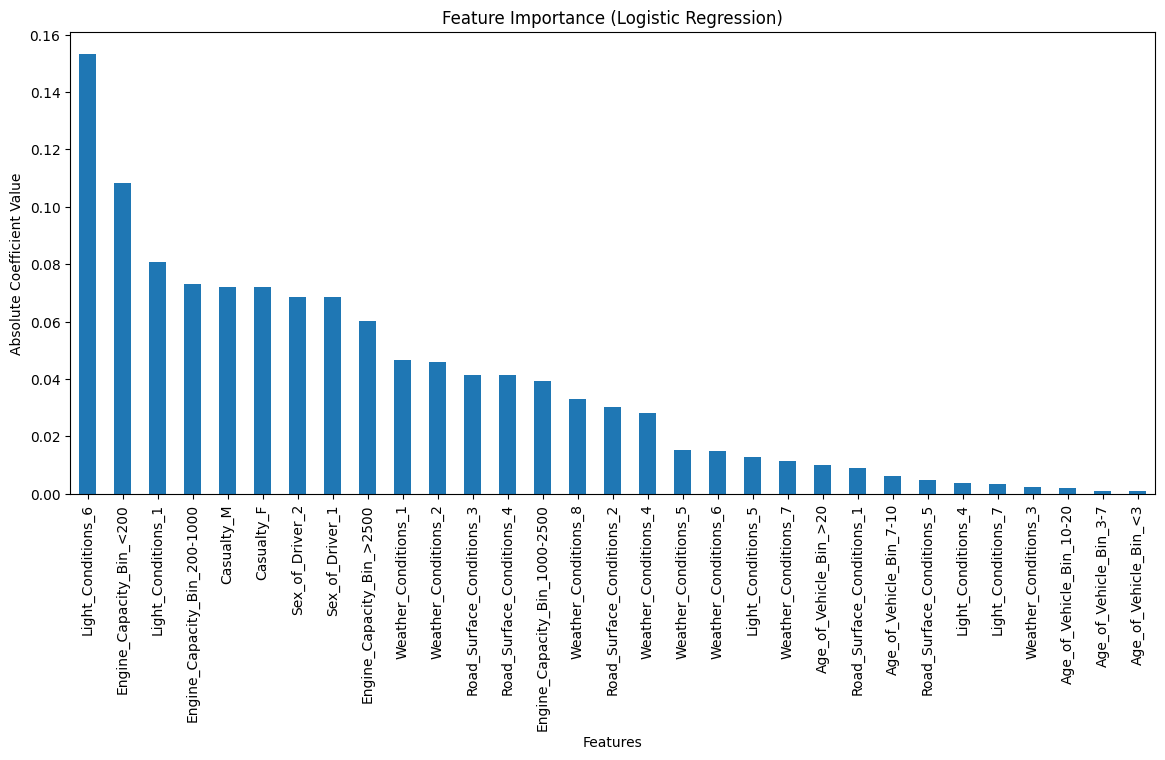

In [ ]:
feature_importance_lr = pd.Series(lreg.coef_[0], index=X.columns)
feature_importance_lr = feature_importance_lr.abs().sort_values(ascending=False)

# Plotting feature importance
plt.figure(figsize=(14, 6))
feature_importance_lr.plot(kind='bar')
plt.title("Feature Importance (Logistic Regression)")
plt.xlabel("Features")
plt.ylabel("Absolute Coefficient Value")
plt.show()

<a style='text-decoration:none;line-height:16px;display:flex;color:#5B5B62;padding:10px;justify-content:end;' href='https://deepnote.com?utm_source=created-in-deepnote-cell&projectId=f5a28ecf-26c4-4017-91db-5192b5973fba' target="_blank">
 </img>
Created in <span style='font-weight:600;margin-left:4px;'>Deepnote</span></a>